In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
Looker_data = pd.read_csv('Looker Data.csv')
Looker_data.head()

,Provider ID,Provider Name,Start Date,State of License
0,153,"Allen, Kami",3/1/21,Florida
1,279,"Allen, Emiko",6/1/21,New York
2,207,"Allen, Annelle",9/1/21,New York
3,437,"Allen, Lenore",10/1/21,New York
4,156,"Allen, Theressa",10/1/21,Florida


In [4]:
Salesforce_data = pd.read_csv('Salesforce Data.csv')
Salesforce_data.head()

,Provider Name,Person Account: Email,Degree,Insurance Program
0,"Allen, Kami",provider_1536@helloalma.com,LCSW,No
1,"Allen, Emiko",provider_279@helloalma.com,LMHC,Yes
2,"Allen, Annelle",provider_2073@helloalma.com,LCSW,Yes
3,"Allen, Lenore",provider_4378@helloalma.com,LMHC,Yes
4,"Allen, Theressa",provider_1569@helloalma.com,LMHC,Yes


In [5]:
#create provider ID column in salesforce data set by extracting first 1-3 digits from email address 
new = Salesforce_data['Person Account: Email'].str.split(r"@", n=-1, expand=True)
Salesforce_data['Provider ID'] = new[0].str.extract('(\d{1,3})')

In [6]:
#Check missing values 
Looker_data[Looker_data['Provider Name'].isna()]
Looker_data[Looker_data.isna().any(axis=1)]

,Provider ID,Provider Name,Start Date,State of License
11,287,"Allen, Delois",NaN,Florida
3466,370,NaN,NaN,New York
3470,115,NaN,11/1/21,New York
3482,175,NaN,10/1/21,New York
3494,333,NaN,9/1/21,Arizona
3538,921,NaN,9/1/21,Texas
3550,214,NaN,11/1/21,New York


In [7]:
#drop rows with unknown dates, since we are trying to stratify providers by membership length 
Looker_data.dropna(subset=['Start Date'], inplace=True) 
Looker_data[Looker_data.isna().any(axis=1)]

,Provider ID,Provider Name,Start Date,State of License
3470,115,NaN,11/1/21,New York
3482,175,NaN,10/1/21,New York
3494,333,NaN,9/1/21,Arizona
3538,921,NaN,9/1/21,Texas
3550,214,NaN,11/1/21,New York


In [8]:
#locate and drop same records in salesforce data set 
Salesforce_data[Salesforce_data['Provider Name'] == 'Allen, Delois']

,Provider Name,Person Account: Email,Degree,Insurance Program,Provider ID
11,"Allen, Delois",provider_2874@helloalma.com,LCSW,Yes,287


In [9]:
Salesforce_data[Salesforce_data['Provider ID'] == 370]

,Provider Name,Person Account: Email,Degree,Insurance Program,Provider ID


In [10]:
Salesforce_data.drop([11, 3461], inplace=True)

In [11]:
#Locate at duplicates in Looker 
Looker_dupes = Looker_data[Looker_data.duplicated(('Provider ID', 'Provider Name', 'Start Date'), keep=False)]
Looker_dupes

,Provider ID,Provider Name,Start Date,State of License
15,185,"Allen, Angeline",9/1/21,Florida
48,185,"Allen, Angeline",9/1/21,New York
55,131,"Aquaman, Zoraida",11/1/21,New York
78,131,"Aquaman, Zoraida",11/1/21,New York
79,131,"Aquaman, Zoraida",11/1/21,New York
145,201,"Archangel, Chaya",11/1/21,New York
193,201,"Archangel, Chaya",11/1/21,Texas
232,820,"Batman, Xiomara",11/1/21,New York
242,820,"Batman, Xiomara",11/1/21,Florida


In [12]:
Looker_data['State of License'].unique()

array(['Florida', 'New York', 'Massachusetts', 'Arizona', 'Texas',
       'New York; New Jersey', 'Florida; New York',
       'Arizona; California; Pennsylvania', 'Connecticut', 'New Jersey',
       'New York; Texas', 'Florida; Rhode Island', 'Florida; Ohio',
       'New Jersey;New York'], dtype=object)

In [13]:
#combine 'State of License' for duplicates with same ID and Provider Name 
Looker_data.loc[[48, 242],'State of License'] = 'Florida; New York'
Looker_data.iloc[193]['State of License'] = 'New York; Texas'

In [14]:
Looker_data.drop_duplicates(subset=['Provider ID', 'Provider Name', 'Start Date'], keep='last', inplace=True) #confirmed duplicates listed have only 1 associated email. Drop duplicates with ID, Name and Start date 
Looker_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 0 to 3553
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Provider ID       3547 non-null   object
 1   Provider Name     3542 non-null   object
 2   Start Date        3547 non-null   object
 3   State of License  3547 non-null   object
dtypes: object(4)
memory usage: 138.6+ KB


In [15]:
#check for duplicate emails in SFDC data
Salesforce_data.loc[Salesforce_data.duplicated(subset=['Person Account: Email'])].size 

0

In [16]:
Salesforce_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 0 to 3548
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Provider Name          3547 non-null   object
 1   Person Account: Email  3547 non-null   object
 2   Degree                 3547 non-null   object
 3   Insurance Program      3547 non-null   object
 4   Provider ID            3546 non-null   object
dtypes: object(5)
memory usage: 166.3+ KB


In [17]:
Salesforce_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 0 to 3548
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Provider Name          3547 non-null   object
 1   Person Account: Email  3547 non-null   object
 2   Degree                 3547 non-null   object
 3   Insurance Program      3547 non-null   object
 4   Provider ID            3546 non-null   object
dtypes: object(5)
memory usage: 166.3+ KB


In [18]:
#1 record with NaN provider ID (Karen Garcia). change value to 0 so we can convert data type 
Salesforce_data[Salesforce_data['Provider ID'].isna()] 

,Provider Name,Person Account: Email,Degree,Insurance Program,Provider ID
1597,"Garcia, Karen",yprice@example.org,PhD,Yes,NaN


In [19]:
#convert provider ID to int for Salesforce. also drop 'Degree' and 'Insurance program' columns, as they are not neede for the scope of this assignment 
Salesforce_data.loc[Salesforce_data['Provider Name']=='Garcia, Karen','Provider ID'] = 0
Salesforce_data['Provider ID'] = Salesforce_data['Provider ID'].astype(int)
Salesforce_data.drop(columns=['Degree', 'Insurance Program'], inplace=True) 

In [20]:
#IDs have character '@'. Extract the digits only
Looker_data['Provider ID'] = Looker_data['Provider ID'].str.extract('(\d{1,})')  

In [21]:
#change provider ID to 0 again for Karen Garcia in Looker. convert provider ID to type int 
Looker_data.loc[Looker_data['Provider Name'] == 'Garcia, Karen', 'Provider ID'] = 0
Looker_data['Provider ID'] = Looker_data['Provider ID'].astype(int)

In [22]:
#convert 'start date' to datetime 
Looker_data['Start Date'] = pd.to_datetime(Looker_data['Start Date'], format='%m/%d/%y')

In [23]:
#locate missing provider names in Looker
Looker_data.fillna('Unknown', inplace=True)
missing_names = Looker_data[Looker_data['Provider Name'] == 'Unknown']
missing_names

,Provider ID,Provider Name,Start Date,State of License
3470,115,Unknown,2021-11-01,New York
3482,175,Unknown,2021-10-01,New York
3494,333,Unknown,2021-09-01,Arizona
3538,921,Unknown,2021-09-01,Texas
3550,214,Unknown,2021-11-01,New York


In [24]:
#Replace missing names in Looker by cross-referencing records in Salesforce data set 
for index, row in missing_names.iterrows():
    id = row['Provider ID']
    looker = Looker_data[Looker_data['Provider ID'] == id]['Provider Name'].tolist()
    sfdc = Salesforce_data[Salesforce_data['Provider ID'] == id]['Provider Name'].tolist()
    for i in sfdc:
        if i not in looker:
            Looker_data.loc[(Looker_data['Provider Name'] == 'Unknown') & (Looker_data['Provider ID'] == id),'Provider Name'] = i 


In [25]:
#join data sets on Provider ID and Provider Name
Combined_data = pd.merge(
    Looker_data, Salesforce_data,
    how='inner',
    on=['Provider ID', 'Provider Name']
)
Combined_data.head(10)

,Provider ID,Provider Name,Start Date,State of License,Person Account: Email
0,153,"Allen, Kami",2021-03-01,Florida,provider_1536@helloalma.com
1,279,"Allen, Emiko",2021-06-01,New York,provider_279@helloalma.com
2,207,"Allen, Annelle",2021-09-01,New York,provider_2073@helloalma.com
3,437,"Allen, Lenore",2021-10-01,New York,provider_4378@helloalma.com
4,156,"Allen, Theressa",2021-10-01,Florida,provider_1569@helloalma.com
5,131,"Allen, Vertie",2021-11-01,New York,provider_1317@helloalma.com
6,106,"Allen, Lizabeth",2021-09-01,Florida,provider_1063@helloalma.com
7,809,"Allen, Theressa",2021-08-01,Florida,provider_809@helloalma.com
8,337,"Allen, Theressa",2021-07-01,Florida,provider_3378@helloalma.com
9,107,"Allen, Margaretta",2021-05-01,Massachusetts,provider_1075@helloalma.com


In [26]:
#drop 'State of License', 'Provider ID' and 'Provider Name' columns, as they are not necessary for answering these questions 
new_combined = Combined_data.drop(columns=['State of License', 'Provider ID', 'Provider Name'])

In [27]:
#load zendesk quarterly tickets table 
Zendesk_1 = pd.read_csv('Zendesk Data - File 1.csv', sep=';')
Zendesk_1.tail()


,Ticket ID,Ticket Type,Requester email,Ticket created - Date,Tickets
9842,175363,Alma Portal Tools::Billing Tools,provider_4387@helloalma.com,44561,1
9843,175365,Member Management::Sales,provider_4388@helloalma.com,44561,1
9844,175370,Member Management::Account Management,provider_4389@helloalma.com,44561,1
9845,175378,Claims,provider_439@helloalma.com,44561,1
9846,175381,Alma Portal Tools::Calendar Tools,provider_4390@helloalma.com,44561,1


In [28]:
#convert excel serial date to datetime 
import datetime as dt
Zendesk_1['Ticket created - Date'] = pd.TimedeltaIndex(Zendesk_1['Ticket created - Date'], unit='d') + dt.datetime(1900,1,1)

In [29]:
#left join ticket table with combined Looker and Salesforce tables 
ticket_combined = pd.merge(
    Zendesk_1, new_combined,
    how='left',
    left_on=['Requester email'],
    right_on=['Person Account: Email']
)
ticket_combined.head(20)

,Ticket ID,Ticket Type,Requester email,Ticket created - Date,Tickets,Start Date,Person Account: Email
0,138304,Client Eligibility,provider_1@helloalma.com,2021-10-03,1,2021-08-01,provider_1@helloalma.com
1,138370,Member Management::Sales,provider_10@helloalma.com,2021-10-03,1,2021-08-01,provider_10@helloalma.com
2,138390,Member Management::Account Management,provider_100@helloalma.com,2021-10-03,1,2021-10-01,provider_100@helloalma.com
3,138391,Credentialing,provider_1001@helloalma.com,2021-10-03,1,2021-11-01,provider_1001@helloalma.com
4,138391,Member Management::Profile Updates,provider_1002@helloalma.com,2021-10-03,1,2021-10-01,provider_1002@helloalma.com
5,138402,Credentialing,provider_1005@helloalma.com,2021-10-03,1,2021-09-01,provider_1005@helloalma.com
6,138403,Client Billing::Insurance,provider_1006@helloalma.com,2021-10-03,1,2021-10-01,provider_1006@helloalma.com
7,138404,Member Management::Profile Updates,provider_1008@helloalma.com,2021-10-03,1,2021-09-01,provider_1008@helloalma.com
8,138405,Client Matching::Matching,provider_101@helloalma.com,2021-10-03,1,2021-10-01,provider_101@helloalma.com
9,138406,Member Management::Account Management,provider_1010@helloalma.com,2021-10-03,1,2021-11-01,provider_1010@helloalma.com


## Question 1: Which types of tickets does the team spend the most time on?

In [30]:
ticket_combined['Ticket ID'].unique().size
ticket_combined[ticket_combined.duplicated(['Ticket ID', 'Ticket Type'], keep=False)]
ticket_combined.drop_duplicates(subset=['Ticket ID', 'Ticket Type'], keep='last')

,Ticket ID,Ticket Type,Requester email,Ticket created - Date,Tickets,Start Date,Person Account: Email
0,138304,Client Eligibility,provider_1@helloalma.com,2021-10-03,1,2021-08-01,provider_1@helloalma.com
1,138370,Member Management::Sales,provider_10@helloalma.com,2021-10-03,1,2021-08-01,provider_10@helloalma.com
2,138390,Member Management::Account Management,provider_100@helloalma.com,2021-10-03,1,2021-10-01,provider_100@helloalma.com
3,138391,Credentialing,provider_1001@helloalma.com,2021-10-03,1,2021-11-01,provider_1001@helloalma.com
4,138391,Member Management::Profile Updates,provider_1002@helloalma.com,2021-10-03,1,2021-10-01,provider_1002@helloalma.com
...,...,...,...,...,...,...,...
9848,175363,Alma Portal Tools::Billing Tools,provider_4387@helloalma.com,2022-01-02,1,2021-11-01,provider_4387@helloalma.com
9849,175365,Member Management::Sales,provider_4388@helloalma.com,2022-01-02,1,2021-06-01,provider_4388@helloalma.com
9850,175370,Member Management::Account Management,provider_4389@helloalma.com,2022-01-02,1,2021-03-01,provider_4389@helloalma.com
9851,175378,Claims,provider_439@helloalma.com,2022-01-02,1,2021-05-01,provider_439@helloalma.com


In [31]:
ticket_time = ticket_combined.drop(columns=['Person Account: Email', 'Requester email', 'Start Date'])
ticket_types1 = Zendesk_1['Ticket Type'].unique().tolist()


In [32]:
#import and clean the second zendesk file with avg time spent for each ticket type 
import csv 
Zendesk_2 = pd.read_csv('Zendesk Data - File 2.csv', sep=';', quoting=csv.QUOTE_NONE)
Zendesk_2['Ticket Type'] = Zendesk_2['"Ticket Type'].str.strip('"')
Zendesk_2['Avg time to Reply (seconds)'] = Zendesk_2['""Avg time to Reply (seconds)"""'].str.strip('"')
Zendesk_2.drop(columns=['"Ticket Type', '""Avg time to Reply (seconds)"""'], inplace=True)
Zendesk_2.drop([24], inplace=True)
Zendesk_2['Avg time to Reply (seconds)'] = Zendesk_2['Avg time to Reply (seconds)'].astype(float)
ticket_types2 = Zendesk_2['Ticket Type'].unique().tolist()

In [33]:
#find which ticket types we have data on in the second Zendesk file 
overlap = [value for value in ticket_types1 if value not in ticket_types2]
overlap

['Client Matching::Matching',
 'Spam',
 'Claims',
 'Client Matching::Non-Matching',
 'Client Matching::Providers']

In [34]:
#drop rows where we do not know the avg time spent on that type of ticket. Merge second zendesk table on 'Ticket Type'
ticket_time = ticket_time[~ticket_time['Ticket Type'].isin(overlap)]
ticket_time = pd.merge(
    ticket_time, Zendesk_2,
    on=['Ticket Type'],
    how='left'
)

In [35]:
ticket_time.head()

,Ticket ID,Ticket Type,Ticket created - Date,Tickets,Avg time to Reply (seconds)
0,138304,Client Eligibility,2021-10-03,1,780.181937
1,138370,Member Management::Sales,2021-10-03,1,425.630273
2,138390,Member Management::Account Management,2021-10-03,1,1194.006392
3,138391,Credentialing,2021-10-03,1,424.385399
4,138391,Member Management::Profile Updates,2021-10-03,1,628.764004


In [38]:
#Calculate total time spent by ticket type (top 5) in hours
time_spent = ticket_time.groupby('Ticket Type')['Avg time to Reply (seconds)'].sum().sort_values(ascending=False)
time_spent2 = round(time_spent[:5]/3600, 2)
time_spent2

Ticket Type
Client Billing::Insurance                447.65
Client Eligibility                       338.08
Member Management::Account Management    203.64
Alma Portal Tools::Billing Tools         128.71
Member Management::Profile Updates       126.63
Name: Avg time to Reply (seconds), dtype: float64

Text(0.5, 0, 'Time spent (hrs)')

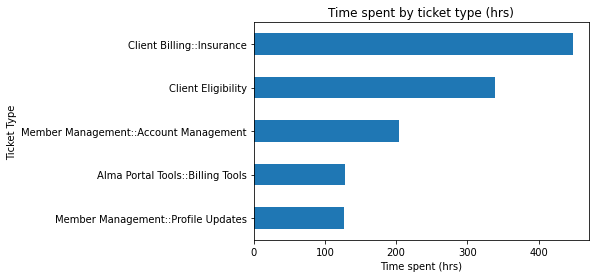

In [40]:
time_vis = time_spent2.sort_values().plot(kind='barh', title='Time spent by ticket type (hrs)')
time_vis.set_xlabel('Time spent (hrs)')

## Question 2: Which providers drive ticket volume? 

In [41]:
#Null values are from 2 distinct accounts, the two records that were dropped from Looker due to missing Start Date 
ticket_combined[ticket_combined.isna().any(axis=1)]

,Ticket ID,Ticket Type,Requester email,Ticket created - Date,Tickets,Start Date,Person Account: Email
1514,143936,Client Billing::Insurance,provider_2874@helloalma.com,2021-10-15,1,NaT,NaN
2186,146578,Member Management::Profile Updates,provider_3704@helloalma.com,2021-10-22,1,NaT,NaN
5065,157497,Member Management::Account Management,provider_2874@helloalma.com,2021-11-17,1,NaT,NaN
5737,159991,Alma Portal Tools::Consultation Tools,provider_3704@helloalma.com,2021-11-23,1,NaT,NaN
8616,170753,Client Billing::Insurance,provider_2874@helloalma.com,2021-12-21,1,NaT,NaN
9288,173395,Client Billing::Insurance,provider_3704@helloalma.com,2021-12-29,1,NaT,NaN


In [42]:
ticket_combined.dropna(inplace=True)
ticket_combined.head()

,Ticket ID,Ticket Type,Requester email,Ticket created - Date,Tickets,Start Date,Person Account: Email
0,138304,Client Eligibility,provider_1@helloalma.com,2021-10-03,1,2021-08-01,provider_1@helloalma.com
1,138370,Member Management::Sales,provider_10@helloalma.com,2021-10-03,1,2021-08-01,provider_10@helloalma.com
2,138390,Member Management::Account Management,provider_100@helloalma.com,2021-10-03,1,2021-10-01,provider_100@helloalma.com
3,138391,Credentialing,provider_1001@helloalma.com,2021-10-03,1,2021-11-01,provider_1001@helloalma.com
4,138391,Member Management::Profile Updates,provider_1002@helloalma.com,2021-10-03,1,2021-10-01,provider_1002@helloalma.com


In [43]:
#find time between start date and ticket request
ticket_combined['time_delta'] = (ticket_combined['Ticket created - Date'] - ticket_combined['Start Date']).dt.days
ticket_combined

,Ticket ID,Ticket Type,Requester email,Ticket created - Date,Tickets,Start Date,Person Account: Email,time_delta
0,138304,Client Eligibility,provider_1@helloalma.com,2021-10-03,1,2021-08-01,provider_1@helloalma.com,63
1,138370,Member Management::Sales,provider_10@helloalma.com,2021-10-03,1,2021-08-01,provider_10@helloalma.com,63
2,138390,Member Management::Account Management,provider_100@helloalma.com,2021-10-03,1,2021-10-01,provider_100@helloalma.com,2
3,138391,Credentialing,provider_1001@helloalma.com,2021-10-03,1,2021-11-01,provider_1001@helloalma.com,-29
4,138391,Member Management::Profile Updates,provider_1002@helloalma.com,2021-10-03,1,2021-10-01,provider_1002@helloalma.com,2
...,...,...,...,...,...,...,...,...
9848,175363,Alma Portal Tools::Billing Tools,provider_4387@helloalma.com,2022-01-02,1,2021-11-01,provider_4387@helloalma.com,62
9849,175365,Member Management::Sales,provider_4388@helloalma.com,2022-01-02,1,2021-06-01,provider_4388@helloalma.com,215
9850,175370,Member Management::Account Management,provider_4389@helloalma.com,2022-01-02,1,2021-03-01,provider_4389@helloalma.com,307
9851,175378,Claims,provider_439@helloalma.com,2022-01-02,1,2021-05-01,provider_439@helloalma.com,246


In [44]:
#only look at values > 0 because we want to see tickets submitted by members 
provider_type = ticket_combined[ticket_combined['time_delta'] >= 0]

#Create bins for new and activated members 
bins = pd.IntervalIndex.from_tuples([(0, 90), (120, np.inf)])
d = dict(zip(bins, ['New', 'Activated']))
provider_type['Provider Type'] = pd.cut(provider_type.time_delta, bins).map(d)
provider_type.drop(columns=['time_delta', 'Person Account: Email'], inplace=True)

#drop NaN values (those between 3 and 4 months) so we just have 'New' and 'Activated'
provider_type.dropna(inplace=True)
provider_type.head()

C:\Users\ehuva\AppData\Local\Temp\ipykernel_3980\46041538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  provider_type['Provider Type'] = pd.cut(provider_type.time_delta, bins).map(d)
C:\Users\ehuva\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\ehuva\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

,Ticket ID,Ticket Type,Requester email,Ticket created - Date,Tickets,Start Date,Provider Type
0,138304,Client Eligibility,provider_1@helloalma.com,2021-10-03,1,2021-08-01,New
1,138370,Member Management::Sales,provider_10@helloalma.com,2021-10-03,1,2021-08-01,New
2,138390,Member Management::Account Management,provider_100@helloalma.com,2021-10-03,1,2021-10-01,New
4,138391,Member Management::Profile Updates,provider_1002@helloalma.com,2021-10-03,1,2021-10-01,New
5,138402,Credentialing,provider_1005@helloalma.com,2021-10-03,1,2021-09-01,New


In [45]:
provider_type['Provider Type'].value_counts()


New          5740
Activated    2493
Name: Provider Type, dtype: int64

Text(0, 0.5, 'Tickets')

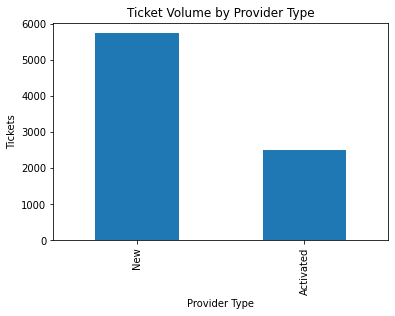

In [46]:
#Ticket count for each provider type (new vs. activated)
provider_vis = provider_type['Provider Type'].value_counts().plot(kind = 'bar', title='Ticket Volume by Provider Type')
provider_vis.set_xlabel('Provider Type')
provider_vis.set_ylabel('Tickets')

In [47]:
# with pd.ExcelWriter('alma1.xlsx') as writer:
#     ticket_time.to_excel(writer, sheet_name='Sheet_name_1')
#     provider_type.to_excel(writer, sheet_name='Sheet_name_2')
    

In [48]:
# with pd.ExcelWriter('alma2.xlsx') as writer:
#     provider_count.to_excel(writer, sheet_name='Sheet_name_3')
#     time_spent2.to_excel(writer, sheet_name='Sheetname_4')